# Sentiment analysis of the Amazon reviews data set

The data set has be downloaded from: https://www.kaggle.com/bittlingmayer/amazonreviews

**In this analysis, I will apply step-by-step process**

# Import necesssary packages, the train and test data sets.

In [33]:
import os
import joblib
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve


In [35]:
# Paths
MODEL_PATH = 'model.pkl'

In [37]:
# Load fastText data
def load_fasttext_format(filepath):
    data = {'label': [], 'review': []}
    with open(filepath, 'r', encoding='utf-8') as file:
        for line in file:
            label, review = line.split(' ', 1)
            data['label'].append(label.replace('__label__', ''))
            data['review'].append(review.strip())
    return pd.DataFrame(data)

train = load_fasttext_format('train.ft.txt').sample(n=10000, random_state=42)
test = load_fasttext_format('test.ft.txt')

# Display the first few rows
print(train.head())
print(test.head())

        label                                             review
2079998     1  Expensive Junk: This product consists of a pie...
1443106     1  Toast too dark: Even on the lowest setting, th...
3463669     2  Excellent imagery...dumbed down story: I enjoy...
2914699     1  Are we pretending everyone is married?: The au...
1603231     1  Not worth your time: Might as well just use a ...
  label                                             review
0     2  Great CD: My lovely Pat has one of the GREAT v...
1     2  One of the best game music soundtracks - for a...
2     1  Batteries died within a year ...: I bought thi...
3     2  works fine, but Maha Energy is better: Check o...
4     2  Great for the non-audiophile: Reviewed quite a...


# Fit Model

In [39]:
# Vectorization (stateless, no need to fit)
vectorizer = HashingVectorizer(n_features=2**18, alternate_sign=False)
X_train = vectorizer.transform(train['review'])
X_test = vectorizer.transform(test['review'])
y_train = train['label'].astype(int)
y_test = test['label'].astype(int)

In [41]:
# Fit or Load Model
if os.path.exists(MODEL_PATH):
    model = joblib.load(MODEL_PATH)
else:
    model = SGDClassifier(loss='log_loss', max_iter=10, n_jobs=-1)
    model.fit(X_train, y_train)
    joblib.dump(model, MODEL_PATH)

In [43]:
# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8411675
Classification Report:
               precision    recall  f1-score   support

           1       0.82      0.87      0.85    200000
           2       0.87      0.81      0.84    200000

    accuracy                           0.84    400000
   macro avg       0.84      0.84      0.84    400000
weighted avg       0.84      0.84      0.84    400000



**Model Interpretation:**

*Overall Accuracy*

- 84.1% of reviews were classified correctly.

- Very good for a simple model and minimal preprocessing.

*Per-Class Performance*

| Label | Precision | Recall | F1-Score | Support |
| ----- | --------- | ------ | -------- | ------- |
| **1** | 0.82      | 0.87   | 0.85     | 200k    |
| **2** | 0.87      | 0.81   | 0.84     | 200k    |


Class 1:

- Recall = 0.87 → Model catches most of the true class 1 cases.

- Precision = 0.82 → Some false positives.

Class 2:

- Recall = 0.81 → Misses more true class 2s compared to class 1.

- Precision = 0.87 → Strong at being sure when it predicts class 2.

Macro Avg: Mean of the metrics across both classes (treats all equally).

Weighted Avg: Weighted by support (useful since both classes are balanced here).

Finally,

- Model is well-balanced, slightly favors recall on class 1 and precision on class 2.

- F1-scores are very close (0.84–0.85) → stable, reliable classifier.

- Great result for SGDClassifier + HashingVectorizer with just 10k training samples!

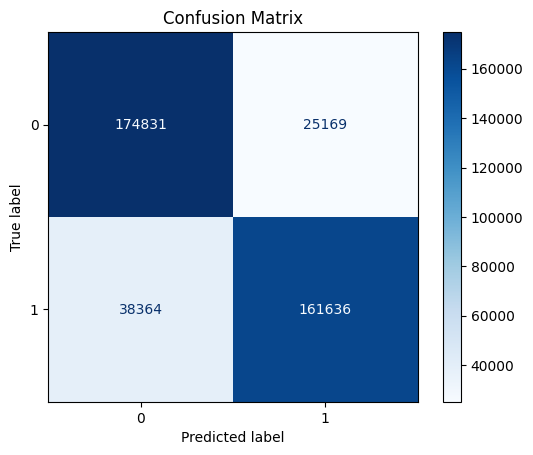

In [52]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

**Confusion Matrix Intuition**

A confusion matrix compares Actual vs. predicted labels:

|               | Predicted: 0         | Predicted: 1         |
| ------------- | -------------------- | -------------------- |
| **True: 0** | True Positives (TP)  | False Negatives (FN) |
| **True: 1** | False Positives (FP) | True Negatives (TN)  |


- Diagonal cells (TP & TN) = correct predictions

- Off-diagonals (FP & FN) = mistakes

- Diagonal cells are dark blue → model is highly accurate

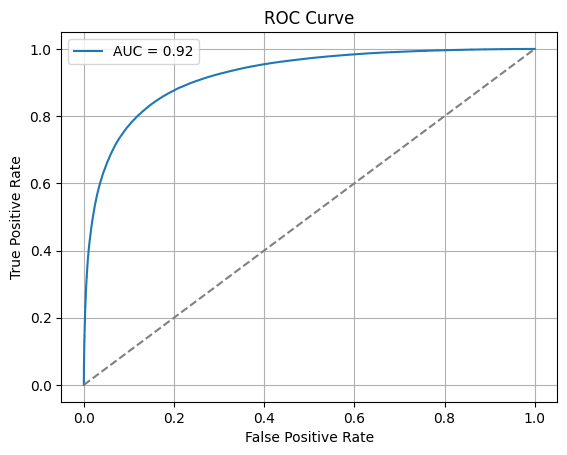

In [54]:
# ROC Curve
if set(y_test.unique()) == {1, 2}:
    y_test_bin = y_test.replace({1: 0, 2: 1})
    y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test_bin, y_score)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test_bin, y_score):.2f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

**ROC Curve Intuition**

ROC Curve = plots True Positive Rate vs False Positive Rate across thresholds

AUC (Area Under Curve) measures separability

- AUC = 0.5 = random guessing

- AUC = 1.0 = perfect classification

- AUC = 0.92 = excellent model (very high signal-to-noise)

This means:

- The model is 92% likely to rank a random positive instance higher than a random negative one.